<a href="https://colab.research.google.com/github/gitHubAndyLee2020/TF_Time_Series_Projects/blob/main/nasdaq_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Uploading Nasdaq Stock data

In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

for filename in uploaded.keys():
  df = pd.read_csv(filename)
  print(f"Data from {filename}:")
  print(df.head())

Saving netflix_stock_history.csv to netflix_stock_history.csv
Saving tesla_stock_history.csv to tesla_stock_history.csv
Saving amazon_stock_history.csv to amazon_stock_history.csv
Saving meta_stock_history.csv to meta_stock_history.csv
Saving microsoft_stock_history.csv to microsoft_stock_history.csv
Saving apple_stock_history.csv to apple_stock_history.csv
Data from netflix_stock_history.csv:
         Date Close/Last   Volume     Open     High        Low
0  08/25/2023    $416.03  5390933  $412.00  $419.25  $407.5641
1  08/24/2023    $406.93  5687799  $425.41  $427.59   $406.165
2  08/23/2023    $427.55  8174732  $418.40  $437.02    $417.71
3  08/22/2023    $413.17  3603273  $409.00  $415.74    $407.40
4  08/21/2023    $408.29  3861579  $402.23  $409.61    $399.50
Data from tesla_stock_history.csv:
         Date Close/Last     Volume       Open       High        Low
0  08/25/2023    $238.59  106612200    $231.31    $239.00    $230.35
1  08/24/2023    $230.04   99777430    $238.66    $2

> Prepping Data for Apple Stock (Experiment Dataset)

In [ ]:
df = pd.read_csv("apple_stock_history.csv", parse_dates=["Date"], index_col=["Date"])
cols_to_format = ['High', 'Low']
for col in cols_to_format:
    df[col] = pd.to_numeric(df[col].str.replace('$', ''), errors='coerce')
df["Price"] = (df["High"] + df["Low"]) / 2
df.drop(['Close/Last', 'Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
df = df.iloc[::-1]
df.head()

<ipython-input-3-b60e9d6b9998>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = pd.to_numeric(df[col].str.replace('$', ''), errors='coerce')


,Price
Date,
2013-08-27,17.65735
2013-08-28,17.53210
2013-08-29,17.63625
2013-08-30,17.49020
2013-09-03,17.64200


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2013-08-27 to 2023-08-25
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Volume  2517 non-null   int64  
 1   Price   2517 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 59.0 KB


In [ ]:
len(df)

2517

In [ ]:
timesteps = df.index.to_numpy()
prices = df["Price"].to_numpy()

In [ ]:
split_size = int(0.8 * len(prices))
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(2013, 504, 2013, 504)

In [ ]:
import matplotlib.pyplot as plt

def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Stock Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

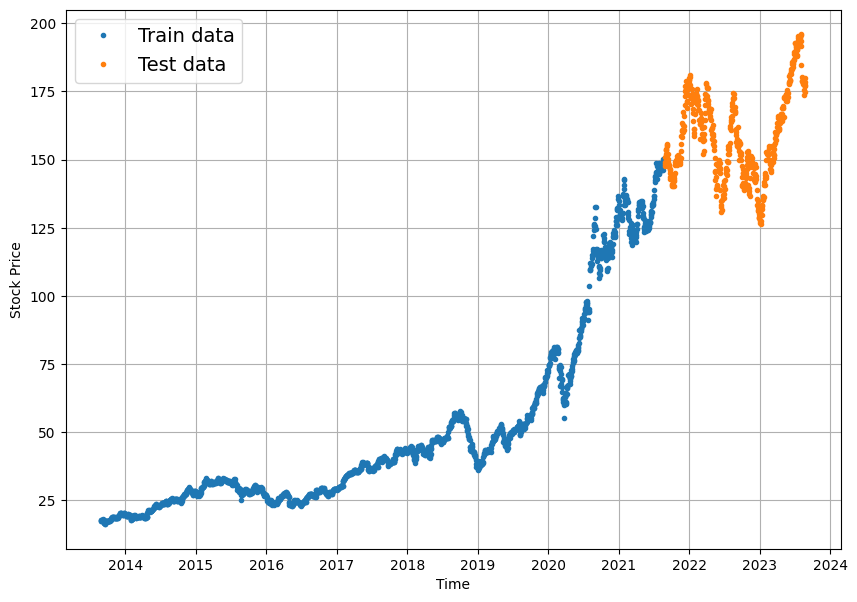

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

> Naive Forecast

- Naive Forecast is used as a baseline for evaluating the performance of other models.

In [ ]:
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([149.06  , 148.315 , 147.79  , 151.05  , 152.045 , 153.66  ,
        153.56  , 153.86  , 155.825 , 155.5075]),
 array([177.585 , 178.4975, 178.265 , 177.52  , 175.4927, 173.53  ,
        174.9325, 176.965 , 179.9375, 178.557 ]))

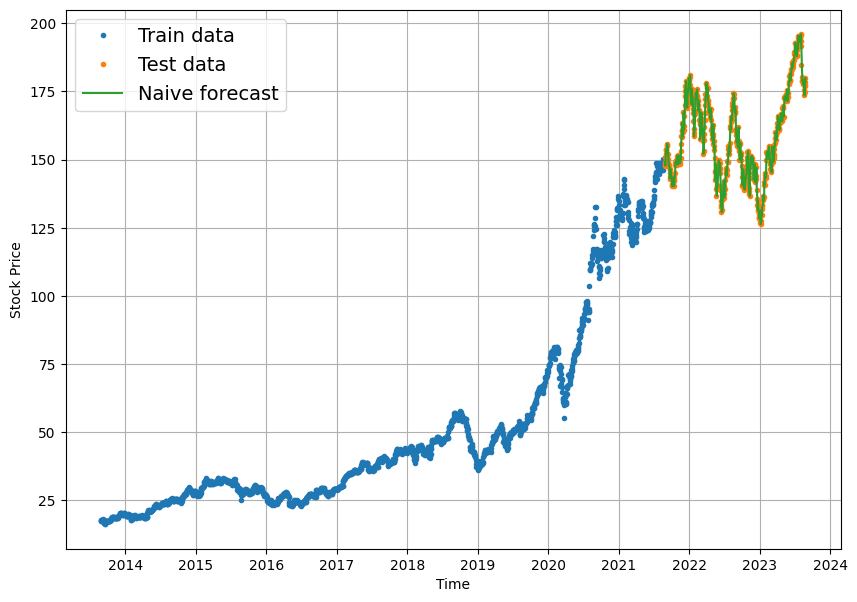

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

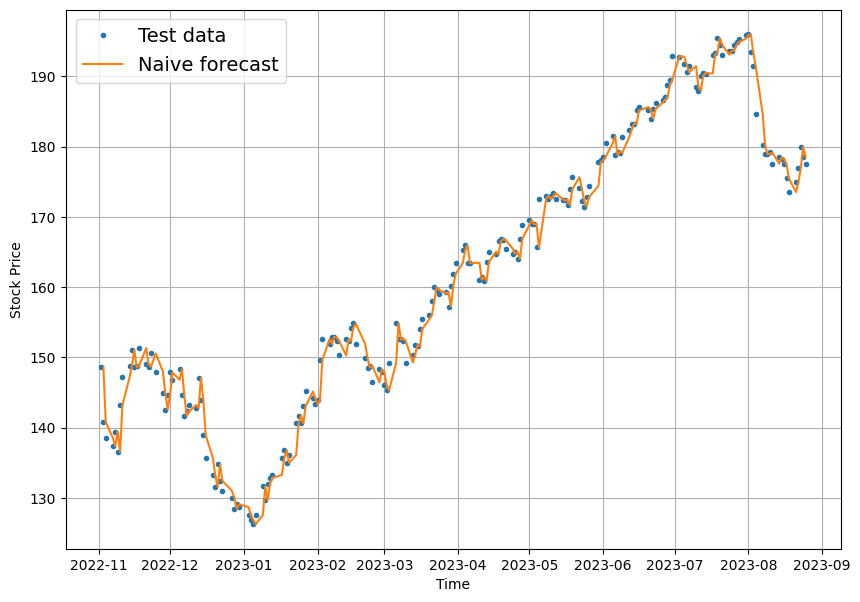

In [ ]:
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 1.8663365,
 'mse': 5.7005854,
 'rmse': 2.38759,
 'mape': 1.1954938,
 'mase': 0.9988045}

In [ ]:
tf.reduce_mean(y_test).numpy()

158.7922076388889

> Format Data with Windowing

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
def get_labelled_windows(x, horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [ ]:
def make_windows(x, window_size=7, horizon=1):
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2503, 2503)

In [ ]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [17.65735 17.5321  17.63625 17.4902  17.642   17.83075 17.7557  17.6666
 18.0607  17.80265 16.75895 16.8109  16.7237  16.2291 ] -> Label: [16.20015]
Window: [17.5321  17.63625 17.4902  17.642   17.83075 17.7557  17.6666  18.0607
 17.80265 16.75895 16.8109  16.7237  16.2291  16.20015] -> Label: [16.55375]
Window: [17.63625 17.4902  17.642   17.83075 17.7557  17.6666  18.0607  17.80265
 16.75895 16.8109  16.7237  16.2291  16.20015 16.55375] -> Label: [16.8764]


In [ ]:
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [191.53   184.65   180.24   178.925  178.97   179.175  177.585  178.4975
 178.265  177.52   175.4927 173.53   174.9325 176.965 ] -> Label: [179.9375]
Window: [184.65   180.24   178.925  178.97   179.175  177.585  178.4975 178.265
 177.52   175.4927 173.53   174.9325 176.965  179.9375] -> Label: [178.557]
Window: [180.24   178.925  178.97   179.175  177.585  178.4975 178.265  177.52
 175.4927 173.53   174.9325 176.965  179.9375 178.557 ] -> Label: [177.485]


In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2002, 501, 2002, 501)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[17.65735, 17.5321 , 17.63625, 17.4902 , 17.642  , 17.83075,
         17.7557 , 17.6666 , 18.0607 , 17.80265, 16.75895, 16.8109 ,
         16.7237 , 16.2291 ],
        [17.5321 , 17.63625, 17.4902 , 17.642  , 17.83075, 17.7557 ,
         17.6666 , 18.0607 , 17.80265, 16.75895, 16.8109 , 16.7237 ,
         16.2291 , 16.20015],
        [17.63625, 17.4902 , 17.642  , 17.83075, 17.7557 , 17.6666 ,
         18.0607 , 17.80265, 16.75895, 16.8109 , 16.7237 , 16.2291 ,
         16.20015, 16.55375],
        [17.4902 , 17.642  , 17.83075, 17.7557 , 17.6666 , 18.0607 ,
         17.80265, 16.75895, 16.8109 , 16.7237 , 16.2291 , 16.20015,
         16.55375, 16.8764 ],
        [17.642  , 17.83075, 17.7557 , 17.6666 , 18.0607 , 17.80265,
         16.75895, 16.8109 , 16.7237 , 16.2291 , 16.20015, 16.55375,
         16.8764 , 16.867  ]]),
 array([[16.20015],
        [16.55375],
        [16.8764 ],
        [16.867  ],
        [17.49125]]))

> Creating Model Checkpoint Callback

In [ ]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

> Checking for Optimal Window and Horizon Size

- First, we will compare the performance of various window and horizon size to find the optimal values before building more sophisticated models.

> Model 1

- Simple dense model.
- WINDOW = 7
- HORIZON = 1

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
 1/16 [>.............................] - ETA: 11s - loss: 72.3895 - mae: 72.3895

16/16 [==============================] - 2s 59ms/step - loss: 49.4082 - mae: 49.4082 - val_loss: 78.1006 - val_mae: 78.1006
Epoch 2/100
 1/16 [>.............................] - ETA: 0s - loss: 24.7053 - mae: 24.7053

16/16 [==============================] - 1s 38ms/step - loss: 10.0613 - mae: 10.0613 - val_loss: 22.6342 - val_mae: 22.6342
Epoch 3/100
 1/16 [>.............................] - ETA: 0s - loss: 6.5548 - mae: 6.5548

16/16 [==============================] - 1s 37ms/step - loss: 3.4613 - mae: 3.4613 - val_loss: 5.0274 - val_mae: 5.0274
Epoch 4/100
 1/16 [>.............................] - ETA: 0s - loss: 1.6210 - mae: 1.6210

16/16 [==============================] - 1s 40ms/step - loss: 1.4524 - mae: 1.4524 - val_loss: 3.8279 - val_mae: 3.8279
Epoch 5/100
 1/16 [>.............................] - ETA: 0s - loss: 1.1927 - mae: 1.1927

16/16 [==============================] - 1s 37ms/step - loss: 1.1049 - mae: 1.1049 - val_loss: 3.5003 - val_mae: 3.5003
Epoch 6/100
 1/16 [>.............................] - ETA: 0s - loss: 1.0145 - mae: 1.0145

16/16 [==============================] - 1s 37ms/step - loss: 1.0596 - mae: 1.0596 - val_loss: 3.4386 - val_mae: 3.4386
Epoch 7/100
 1/16 [>.............................] - ETA: 0s - loss: 0.9614 - mae: 0.9614

16/16 [==============================] - 1s 38ms/step - loss: 1.0291 - mae: 1.0291 - val_loss: 3.4140 - val_mae: 3.4140
Epoch 8/100
 1/16 [>.............................] - ETA: 0s - loss: 0.8843 - mae: 0.8843

16/16 [==============================] - 1s 37ms/step - loss: 1.0185 - mae: 1.0185 - val_loss: 3.3826 - val_mae: 3.3826
Epoch 9/100
16/16 [==============================] - 0s 4ms/step - loss: 1.0401 - mae: 1.0401 - val_loss: 3.4430 - val_mae: 3.4430
Epoch 10/100
 1/16 [>.............................] - ETA: 0s - loss: 1.0186 - mae: 1.0186

16/16 [==============================] - 1s 36ms/step - loss: 1.0209 - mae: 1.0209 - val_loss: 3.3759 - val_mae: 3.3759
Epoch 11/100
16/16 [==============================] - 0s 4ms/step - loss: 1.0340 - mae: 1.0340 - val_loss: 3.4063 - val_mae: 3.4063
Epoch 12/100
 1/16 [>.............................] - ETA: 0s - loss: 1.0227 - mae: 1.0227

16/16 [==============================] - 1s 53ms/step - loss: 1.0040 - mae: 1.0040 - val_loss: 3.3314 - val_mae: 3.3314
Epoch 13/100
 1/16 [>.............................] - ETA: 0s - loss: 0.9719 - mae: 0.9719

16/16 [==============================] - 1s 36ms/step - loss: 0.9979 - mae: 0.9979 - val_loss: 3.3219 - val_mae: 3.3219
Epoch 14/100
16/16 [==============================] - 0s 4ms/step - loss: 0.9908 - mae: 0.9908 - val_loss: 3.3454 - val_mae: 3.3454
Epoch 15/100
16/16 [==============================] - 0s 4ms/step - loss: 0.9929 - mae: 0.9929 - val_loss: 3.3356 - val_mae: 3.3356
Epoch 16/100
16/16 [==============================] - 0s 4ms/step - loss: 1.0141 - mae: 1.0141 - val_loss: 3.5295 - val_mae: 3.5295
Epoch 17/100
 1/16 [>.............................] - ETA: 0s - loss: 0.9733 - mae: 0.9733

16/16 [==============================] - 1s 36ms/step - loss: 0.9878 - mae: 0.9878 - val_loss: 3.2550 - val_mae: 3.2550
Epoch 18/100
 1/16 [>.............................] - ETA: 0s - loss: 0.8044 - mae: 0.8044

16/16 [==============================] - 1s 36ms/step - loss: 0.9763 - mae: 0.9763 - val_loss: 3.2404 - val_mae: 3.2404
Epoch 19/100
 1/16 [>.............................] - ETA: 0s - loss: 1.0085 - mae: 1.0085

16/16 [==============================] - 1s 36ms/step - loss: 0.9751 - mae: 0.9751 - val_loss: 3.2280 - val_mae: 3.2280
Epoch 20/100
16/16 [==============================] - 0s 4ms/step - loss: 0.9660 - mae: 0.9660 - val_loss: 3.2304 - val_mae: 3.2304
Epoch 21/100
 1/16 [>.............................] - ETA: 0s - loss: 0.9120 - mae: 0.9120

16/16 [==============================] - 1s 36ms/step - loss: 0.9804 - mae: 0.9804 - val_loss: 3.1991 - val_mae: 3.1991
Epoch 22/100
16/16 [==============================] - 0s 4ms/step - loss: 0.9570 - mae: 0.9570 - val_loss: 3.2463 - val_mae: 3.2463
Epoch 23/100
16/16 [==============================] - 0s 4ms/step - loss: 0.9608 - mae: 0.9608 - val_loss: 3.2736 - val_mae: 3.2736
Epoch 24/100
 1/16 [>.............................] - ETA: 0s - loss: 0.9087 - mae: 0.9087

16/16 [==============================] - 1s 36ms/step - loss: 0.9450 - mae: 0.9450 - val_loss: 3.1738 - val_mae: 3.1738
Epoch 25/100
 1/16 [>.............................] - ETA: 0s - loss: 0.9446 - mae: 0.9446

16/16 [==============================] - 1s 36ms/step - loss: 0.9306 - mae: 0.9306 - val_loss: 3.1517 - val_mae: 3.1517
Epoch 26/100
 1/16 [>.............................] - ETA: 0s - loss: 0.8764 - mae: 0.8764

16/16 [==============================] - 1s 36ms/step - loss: 0.9301 - mae: 0.9301 - val_loss: 3.1461 - val_mae: 3.1461
Epoch 27/100
16/16 [==============================] - 0s 4ms/step - loss: 0.9286 - mae: 0.9286 - val_loss: 3.2074 - val_mae: 3.2074
Epoch 28/100
16/16 [==============================] - 0s 4ms/step - loss: 0.9478 - mae: 0.9478 - val_loss: 3.4098 - val_mae: 3.4098
Epoch 29/100
 1/16 [>.............................] - ETA: 0s - loss: 0.9936 - mae: 0.9936

16/16 [==============================] - 1s 37ms/step - loss: 0.9191 - mae: 0.9191 - val_loss: 3.0749 - val_mae: 3.0749
Epoch 30/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7149 - mae: 0.7149

16/16 [==============================] - 1s 36ms/step - loss: 0.9101 - mae: 0.9101 - val_loss: 3.0388 - val_mae: 3.0388
Epoch 31/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7706 - mae: 0.7706

16/16 [==============================] - 1s 35ms/step - loss: 0.9112 - mae: 0.9112 - val_loss: 3.0205 - val_mae: 3.0205
Epoch 32/100
16/16 [==============================] - 0s 4ms/step - loss: 0.9422 - mae: 0.9422 - val_loss: 3.4607 - val_mae: 3.4607
Epoch 33/100
16/16 [==============================] - 0s 4ms/step - loss: 0.9284 - mae: 0.9284 - val_loss: 3.2140 - val_mae: 3.2140
Epoch 34/100
 1/16 [>.............................] - ETA: 0s - loss: 0.9330 - mae: 0.9330

16/16 [==============================] - 1s 36ms/step - loss: 0.9152 - mae: 0.9152 - val_loss: 2.9823 - val_mae: 2.9823
Epoch 35/100
 1/16 [>.............................] - ETA: 0s - loss: 0.8011 - mae: 0.8011

16/16 [==============================] - 1s 35ms/step - loss: 0.8898 - mae: 0.8898 - val_loss: 2.9547 - val_mae: 2.9547
Epoch 36/100
 1/16 [>.............................] - ETA: 0s - loss: 1.1843 - mae: 1.1843

16/16 [==============================] - 1s 35ms/step - loss: 0.8931 - mae: 0.8931 - val_loss: 2.9547 - val_mae: 2.9547
Epoch 37/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7315 - mae: 0.7315

16/16 [==============================] - 1s 55ms/step - loss: 0.8926 - mae: 0.8926 - val_loss: 2.9300 - val_mae: 2.9300
Epoch 38/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8954 - mae: 0.8954 - val_loss: 3.0145 - val_mae: 3.0145
Epoch 39/100
 1/16 [>.............................] - ETA: 0s - loss: 0.9443 - mae: 0.9443

16/16 [==============================] - 1s 37ms/step - loss: 0.8732 - mae: 0.8732 - val_loss: 2.9044 - val_mae: 2.9044
Epoch 40/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8741 - mae: 0.8741 - val_loss: 3.0094 - val_mae: 3.0094
Epoch 41/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8561 - mae: 0.8561 - val_loss: 2.9175 - val_mae: 2.9175
Epoch 42/100
 1/16 [>.............................] - ETA: 0s - loss: 0.9251 - mae: 0.9251

16/16 [==============================] - 1s 35ms/step - loss: 0.8739 - mae: 0.8739 - val_loss: 2.8448 - val_mae: 2.8448
Epoch 43/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8535 - mae: 0.8535 - val_loss: 2.8701 - val_mae: 2.8701
Epoch 44/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8726 - mae: 0.8726 - val_loss: 3.0130 - val_mae: 3.0130
Epoch 45/100
 1/16 [>.............................] - ETA: 0s - loss: 0.8587 - mae: 0.8587

16/16 [==============================] - 1s 36ms/step - loss: 0.8746 - mae: 0.8746 - val_loss: 2.8228 - val_mae: 2.8228
Epoch 46/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7848 - mae: 0.7848

16/16 [==============================] - 1s 35ms/step - loss: 0.8287 - mae: 0.8287 - val_loss: 2.8024 - val_mae: 2.8024
Epoch 47/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7446 - mae: 0.7446

16/16 [==============================] - 1s 35ms/step - loss: 0.8296 - mae: 0.8296 - val_loss: 2.7763 - val_mae: 2.7763
Epoch 48/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7738 - mae: 0.7738

16/16 [==============================] - 1s 36ms/step - loss: 0.8320 - mae: 0.8320 - val_loss: 2.7546 - val_mae: 2.7546
Epoch 49/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7640 - mae: 0.7640

16/16 [==============================] - 1s 35ms/step - loss: 0.8393 - mae: 0.8393 - val_loss: 2.7398 - val_mae: 2.7398
Epoch 50/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8228 - mae: 0.8228 - val_loss: 2.9076 - val_mae: 2.9076
Epoch 51/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8224 - mae: 0.8224 - val_loss: 2.7658 - val_mae: 2.7658
Epoch 52/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7963 - mae: 0.7963

16/16 [==============================] - 1s 36ms/step - loss: 0.8159 - mae: 0.8159 - val_loss: 2.6929 - val_mae: 2.6929
Epoch 53/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8511 - mae: 0.8511 - val_loss: 2.8443 - val_mae: 2.8443
Epoch 54/100
 1/16 [>.............................] - ETA: 0s - loss: 0.8600 - mae: 0.8600

16/16 [==============================] - 1s 36ms/step - loss: 0.8143 - mae: 0.8143 - val_loss: 2.6668 - val_mae: 2.6668
Epoch 55/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8278 - mae: 0.8278 - val_loss: 2.7981 - val_mae: 2.7981
Epoch 56/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8005 - mae: 0.8005 - val_loss: 2.6930 - val_mae: 2.6930
Epoch 57/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7934 - mae: 0.7934 - val_loss: 2.8136 - val_mae: 2.8136
Epoch 58/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7100 - mae: 0.7100

16/16 [==============================] - 1s 36ms/step - loss: 0.7899 - mae: 0.7899 - val_loss: 2.6356 - val_mae: 2.6356
Epoch 59/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7997 - mae: 0.7997 - val_loss: 2.8150 - val_mae: 2.8150
Epoch 60/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6017 - mae: 0.6017

16/16 [==============================] - 1s 36ms/step - loss: 0.7751 - mae: 0.7751 - val_loss: 2.6280 - val_mae: 2.6280
Epoch 61/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7969 - mae: 0.7969

16/16 [==============================] - 1s 36ms/step - loss: 0.7634 - mae: 0.7634 - val_loss: 2.5775 - val_mae: 2.5775
Epoch 62/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7732 - mae: 0.7732 - val_loss: 2.7143 - val_mae: 2.7143
Epoch 63/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7610 - mae: 0.7610 - val_loss: 2.6379 - val_mae: 2.6379
Epoch 64/100
 1/16 [>.............................] - ETA: 0s - loss: 0.8666 - mae: 0.8666

16/16 [==============================] - 1s 37ms/step - loss: 0.7789 - mae: 0.7789 - val_loss: 2.5450 - val_mae: 2.5450
Epoch 65/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7485 - mae: 0.7485 - val_loss: 2.5475 - val_mae: 2.5475
Epoch 66/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7509 - mae: 0.7509 - val_loss: 2.5453 - val_mae: 2.5453
Epoch 67/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7440 - mae: 0.7440 - val_loss: 2.5816 - val_mae: 2.5816
Epoch 68/100
16/16 [==============================] - 0s 4ms/step - loss: 0.8095 - mae: 0.8095 - val_loss: 2.9398 - val_mae: 2.9398
Epoch 69/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7990 - mae: 0.7990 - val_loss: 2.6981 - val_mae: 2.6981
Epoch 70/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7716 - mae: 0.7716

16/16 [==============================] - 1s 36ms/step - loss: 0.7342 - mae: 0.7342 - val_loss: 2.4903 - val_mae: 2.4903
Epoch 71/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7355 - mae: 0.7355 - val_loss: 2.8446 - val_mae: 2.8446
Epoch 72/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7539 - mae: 0.7539 - val_loss: 2.6159 - val_mae: 2.6159
Epoch 73/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7479 - mae: 0.7479 - val_loss: 2.7659 - val_mae: 2.7659
Epoch 74/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7329 - mae: 0.7329

16/16 [==============================] - 1s 54ms/step - loss: 0.7785 - mae: 0.7785 - val_loss: 2.4562 - val_mae: 2.4562
Epoch 75/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7411 - mae: 0.7411 - val_loss: 2.5036 - val_mae: 2.5036
Epoch 76/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7400 - mae: 0.7400 - val_loss: 2.5561 - val_mae: 2.5561
Epoch 77/100
 1/16 [>.............................] - ETA: 0s - loss: 0.8121 - mae: 0.8121

16/16 [==============================] - 1s 37ms/step - loss: 0.7210 - mae: 0.7210 - val_loss: 2.4422 - val_mae: 2.4422
Epoch 78/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5912 - mae: 0.5912

16/16 [==============================] - 1s 36ms/step - loss: 0.7449 - mae: 0.7449 - val_loss: 2.4099 - val_mae: 2.4099
Epoch 79/100
 1/16 [>.............................] - ETA: 0s - loss: 0.4713 - mae: 0.4713

16/16 [==============================] - 1s 37ms/step - loss: 0.7081 - mae: 0.7081 - val_loss: 2.4033 - val_mae: 2.4033
Epoch 80/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6915 - mae: 0.6915

16/16 [==============================] - 1s 37ms/step - loss: 0.7203 - mae: 0.7203 - val_loss: 2.4001 - val_mae: 2.4001
Epoch 81/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6990 - mae: 0.6990 - val_loss: 2.4725 - val_mae: 2.4725
Epoch 82/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7489 - mae: 0.7489 - val_loss: 2.6895 - val_mae: 2.6895
Epoch 83/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7714 - mae: 0.7714 - val_loss: 2.7107 - val_mae: 2.7107
Epoch 84/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7535 - mae: 0.7535 - val_loss: 2.6984 - val_mae: 2.6984
Epoch 85/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7183 - mae: 0.7183 - val_loss: 2.4292 - val_mae: 2.4292
Epoch 86/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6981 - mae: 0.6981

16/16 [==============================] - 1s 37ms/step - loss: 0.7319 - mae: 0.7319 - val_loss: 2.3498 - val_mae: 2.3498
Epoch 87/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6875 - mae: 0.6875 - val_loss: 2.3627 - val_mae: 2.3627
Epoch 88/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6955 - mae: 0.6955 - val_loss: 2.5133 - val_mae: 2.5133
Epoch 89/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7333 - mae: 0.7333 - val_loss: 2.5368 - val_mae: 2.5368
Epoch 90/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7420 - mae: 0.7420 - val_loss: 2.8518 - val_mae: 2.8518
Epoch 91/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7024 - mae: 0.7024 - val_loss: 2.3963 - val_mae: 2.3963
Epoch 92/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6681 - mae: 0.6681

16/16 [==============================] - 1s 36ms/step - loss: 0.6928 - mae: 0.6928 - val_loss: 2.3386 - val_mae: 2.3386
Epoch 93/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6689 - mae: 0.6689

16/16 [==============================] - 1s 36ms/step - loss: 0.6744 - mae: 0.6744 - val_loss: 2.3200 - val_mae: 2.3200
Epoch 94/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6756 - mae: 0.6756 - val_loss: 2.4144 - val_mae: 2.4144
Epoch 95/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6938 - mae: 0.6938 - val_loss: 2.3350 - val_mae: 2.3350
Epoch 96/100
16/16 [==============================] - 0s 4ms/step - loss: 0.7428 - mae: 0.7428 - val_loss: 2.3382 - val_mae: 2.3382
Epoch 97/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7698 - mae: 0.7698

16/16 [==============================] - 1s 35ms/step - loss: 0.6914 - mae: 0.6914 - val_loss: 2.2922 - val_mae: 2.2922
Epoch 98/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6459 - mae: 0.6459

16/16 [==============================] - 1s 36ms/step - loss: 0.6753 - mae: 0.6753 - val_loss: 2.2848 - val_mae: 2.2848
Epoch 99/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6790 - mae: 0.6790 - val_loss: 2.3348 - val_mae: 2.3348
Epoch 100/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6703 - mae: 0.6703 - val_loss: 2.3084 - val_mae: 2.3084


In [ ]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 1ms/step - loss: 2.2848 - mae: 2.2848


[2.2848446369171143, 2.2848446369171143]

In [ ]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [ ]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

16/16 [==============================] - 0s 1ms/step


(502,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([149.01619, 148.45232, 149.73093, 151.16135, 152.77017, 153.63867,
        153.99573, 155.19728, 155.56711, 155.51701], dtype=float32)>)

In [ ]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
print("model_1_results:\n", model_1_results)
print("naive_results:\n", naive_results)

model_1_results:
 {'mae': 2.2848442, 'mse': 8.429027, 'rmse': 2.9032786, 'mape': 1.4622018, 'mase': 1.2210243}
naive_results:
 {'mae': 1.8663365, 'mse': 5.7005854, 'rmse': 2.38759, 'mape': 1.1954938, 'mase': 0.9988045}


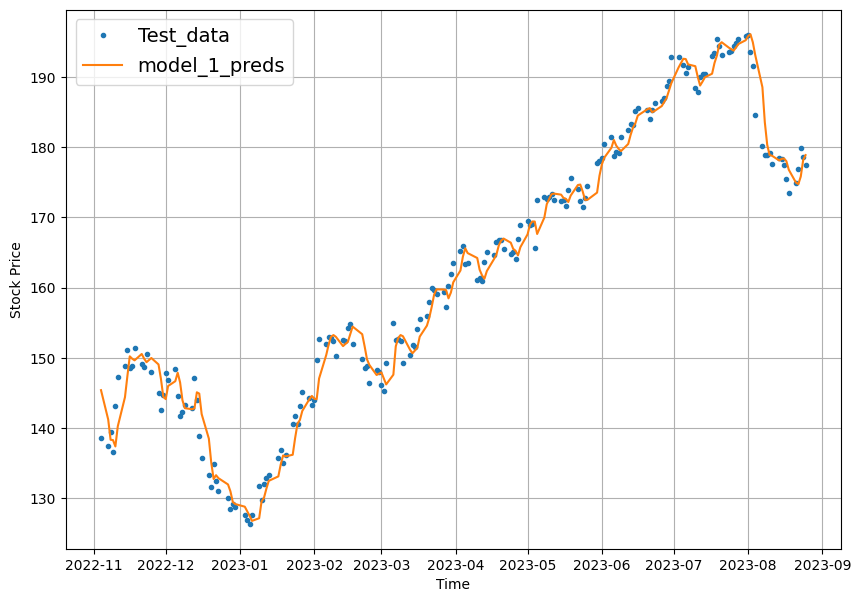

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

- The current model is performing worst then the baseline model.

> Model 2

- Simple dense model.
- WINDOW = 30
- HORIZON = 1

In [ ]:
HORIZON = 1
WINDOW_SIZE = 30

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2487, 2487)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1989, 498, 1989, 498)

In [ ]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 1ms/step - loss: 2.3928


2.3928298950195312

In [ ]:
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

16/16 [==============================] - 0s 1ms/step


In [ ]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
print("model_2_results:\n", model_2_results)
print("naive_results:\n", naive_results)

model_2_results:
 {'mae': 2.3928292, 'mse': 9.558344, 'rmse': 3.0916572, 'mape': 1.5273331, 'mase': 1.276652}
naive_results:
 {'mae': 1.8663365, 'mse': 5.7005854, 'rmse': 2.38759, 'mape': 1.1954938, 'mase': 0.9988045}


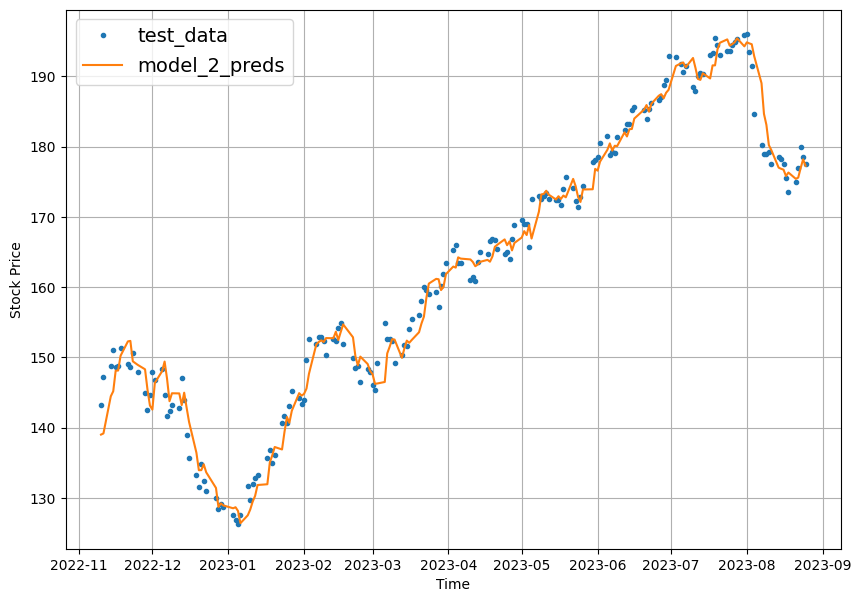

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

> Model 3

- Simple dense model.
- WINDOW = 30
- HORIZON = 7

In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2481, 2481)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1984, 497, 1984, 497)

In [ ]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 1ms/step - loss: 4.6921


4.692076683044434

In [ ]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

16/16 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[148.82315, 151.22626, 149.4658 , 148.6595 , 148.57838, 147.09486,
        149.41925],
       [147.78802, 150.7865 , 148.4487 , 147.18686, 148.65916, 146.12975,
        148.54526],
       [147.87183, 150.34729, 149.37996, 148.19463, 149.4087 , 147.08073,
        148.20413],
       [148.1288 , 150.52008, 149.76093, 149.20258, 150.05289, 148.29547,
        148.43465],
       [149.22327, 150.9506 , 151.30493, 150.77267, 151.06776, 149.35199,
        149.03035]], dtype=float32)>

In [ ]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
print("model_3_results:\n", model_3_results)
print("naive_results:\n", naive_results)

model_3_results:
 {'mae': 4.6920776, 'mse': 36.25949, 'rmse': 5.3349004, 'mape': 2.997744, 'mase': 2.505793}
naive_results:
 {'mae': 1.8663365, 'mse': 5.7005854, 'rmse': 2.38759, 'mape': 1.1954938, 'mase': 0.9988045}


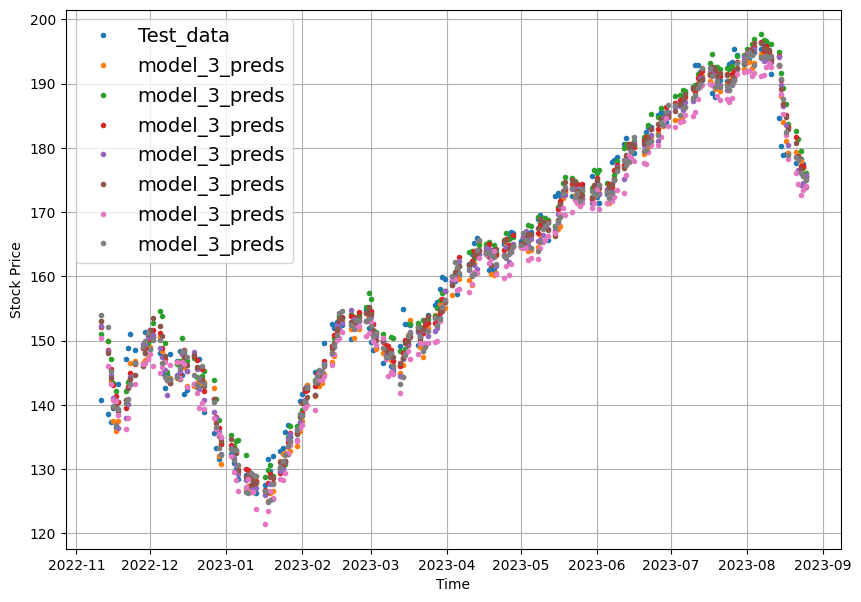

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

> Model 4

- Simple dense model.
- WINDOW = 14
- HORIZON = 1

In [ ]:
HORIZON = 1
WINDOW_SIZE = 14

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2503, 2503)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2002, 501, 2002, 501)

In [ ]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_dense")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_dense/")
model_4.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 2.2359


2.2358951568603516

In [ ]:
model_4_preds = make_preds(model_4,
                           input_data=test_windows)
model_4_preds[:5]

16/16 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([148.6782 , 149.78111, 151.50641, 153.26462, 153.98749],
      dtype=float32)>

In [ ]:
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
print("model_4_results:\n", model_4_results)
print("naive_results:\n", naive_results)

model_4_results:
 {'mae': 2.2358956, 'mse': 8.229485, 'rmse': 2.868708, 'mape': 1.432765, 'mase': 1.1966423}
naive_results:
 {'mae': 1.8663365, 'mse': 5.7005854, 'rmse': 2.38759, 'mape': 1.1954938, 'mase': 0.9988045}


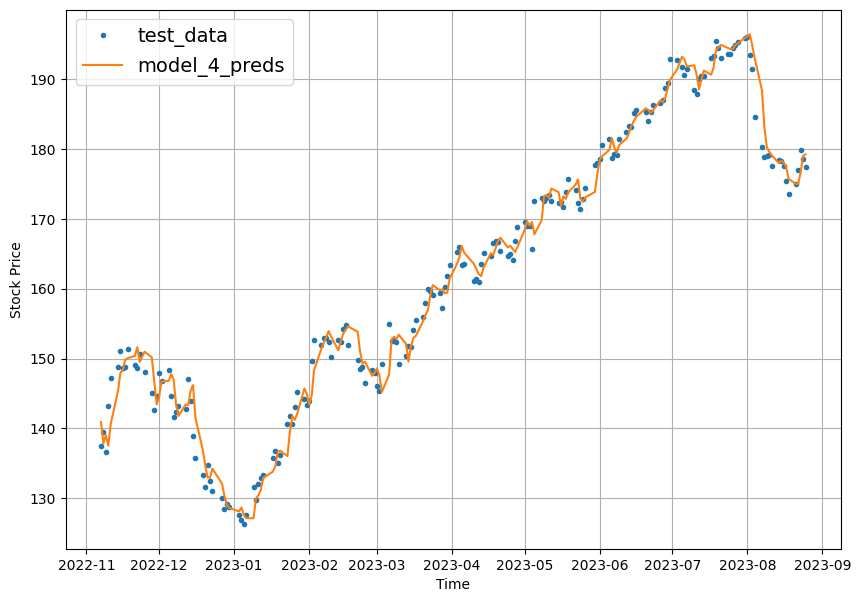

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_4_preds, start=offset, format="-", label="model_4_preds")

> Comparing Performance between Various Window and Horizon Values

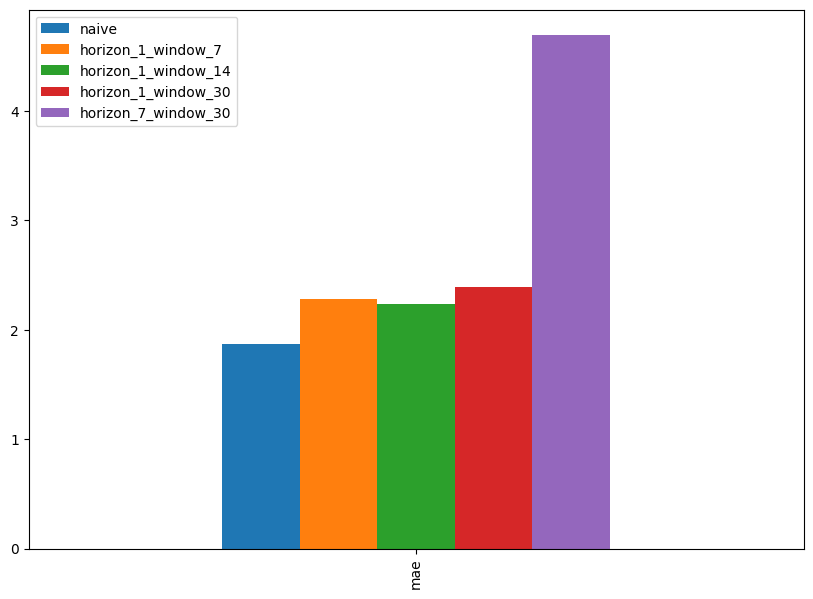

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_14": model_4_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

- WINDOW = 14; HORIZON = 1 performs the best on the dataset, so these values will be used for future models.

> Model 5

- CNN (Conv1D)

In [ ]:
HORIZON = 1
WINDOW_SIZE = 14

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2503, 2503)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2002, 501, 2002, 501)

In [ ]:
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (14,)
Expanded shape: (14, 1)
Original values with expanded shape:
 [[17.65735]
 [17.5321 ]
 [17.63625]
 [17.4902 ]
 [17.642  ]
 [17.83075]
 [17.7557 ]
 [17.6666 ]
 [18.0607 ]
 [17.80265]
 [16.75895]
 [16.8109 ]
 [16.7237 ]
 [16.2291 ]]


In [ ]:
tf.random.set_seed(42)

model_5 = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_5_conv1D")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
model_5.summary()

Model: "model_5_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 1, 14)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            9088      
                                                                 
 dense_16 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_5 = tf.keras.models.load_model("model_experiments/model_5_conv1D")
model_5.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 1ms/step - loss: 2.5443


2.5442683696746826

In [ ]:
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

16/16 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([148.87724, 149.72647, 150.91368, 152.53899, 153.64365, 154.37498,
       155.21284, 155.8492 , 156.06154, 155.18587], dtype=float32)>

In [ ]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
print("model_5_results:\n", model_5_results)
print("naive_results:\n", naive_results)

model_5_results:
 {'mae': 2.5442684, 'mse': 10.901638, 'rmse': 3.3017628, 'mape': 1.6305556, 'mase': 1.361682}
naive_results:
 {'mae': 1.8663365, 'mse': 5.7005854, 'rmse': 2.38759, 'mape': 1.1954938, 'mase': 0.9988045}


> Model 6

- RNN (LSTM)

In [ ]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_6 = tf.keras.Model(inputs=inputs, outputs=output, name="model_6_lstm")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_6.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [ ]:
model_6 = tf.keras.models.load_model("model_experiments/model_6_lstm/")
model_6.evaluate(test_windows, test_labels)

16/16 [==============================] - 0s 2ms/step - loss: 2.1718


2.171828031539917

In [ ]:
model_6_preds = make_preds(model_6, test_windows)
model_6_preds[:10]

16/16 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([147.95975, 150.2091 , 151.04951, 153.85445, 154.94409, 155.58713,
       154.98657, 155.65535, 155.65157, 154.06485], dtype=float32)>

In [ ]:
model_6_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_6_preds)
print("model_6_results:\n", model_6_results)
print("naive_results:\n", naive_results)

model_6_results:
 {'mae': 2.1718278, 'mse': 8.081162, 'rmse': 2.8427386, 'mape': 1.393582, 'mase': 1.1623534}
naive_results:
 {'mae': 1.8663365, 'mse': 5.7005854, 'rmse': 2.38759, 'mape': 1.1954938, 'mase': 0.9988045}


> Model 7

- N-BEATS Algorithm

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 14), dtype=int32, numpy=
array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]],
      dtype=int32)>

In [ ]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-2.1131344   0.44898975  1.3553612   2.5223527  -0.91887593 -3.1941438
 -0.7524811   1.8995894   0.12724051 -0.1690697   0.67330176  0.53038794
 -0.9600102  -2.1886954 ]
Forecast: 0.3408331573009491


In [ ]:
HORIZON = 1
WINDOW_SIZE = 14

In [ ]:
df_nbeats = df.copy()
df_nbeats
for i in range(WINDOW_SIZE):
  df_nbeats[f"Price+{i+1}"] = df_nbeats["Price"].shift(periods=i+1)
df_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,Price+8,Price+9,Price+10,Price+11,Price+12,Price+13,Price+14
Date,,,,,,,,,,,,,,,
2013-09-17,16.20015,16.22910,16.72370,16.81090,16.75895,17.80265,18.06070,17.66660,17.75570,17.83075,17.64200,17.49020,17.63625,17.53210,17.65735
2013-09-18,16.55375,16.20015,16.22910,16.72370,16.81090,16.75895,17.80265,18.06070,17.66660,17.75570,17.83075,17.64200,17.49020,17.63625,17.53210
2013-09-19,16.87640,16.55375,16.20015,16.22910,16.72370,16.81090,16.75895,17.80265,18.06070,17.66660,17.75570,17.83075,17.64200,17.49020,17.63625
2013-09-20,16.86700,16.87640,16.55375,16.20015,16.22910,16.72370,16.81090,16.75895,17.80265,18.06070,17.66660,17.75570,17.83075,17.64200,17.49020
2013-09-23,17.49125,16.86700,16.87640,16.55375,16.20015,16.22910,16.72370,16.81090,16.75895,17.80265,18.06070,17.66660,17.75570,17.83075,17.64200


In [ ]:
X = df_nbeats.dropna().drop("Price", axis=1)
y = df_nbeats.dropna()["Price"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2002, 2002, 501, 501)

In [ ]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [ ]:
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(14, 15)

In [ ]:
 %%time

tf.random.set_seed(42)

nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")
backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

for i, _ in enumerate(range(N_STACKS-1)):

  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[create_model_checkpoint(model_name=model_7.name),
                       tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 367: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.



Epoch 600: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 700: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 3h 15min 51s, sys: 10min 9s, total: 3h 26min 1s
Wall time: 45min 29s


In [ ]:
model_7 = tf.keras.models.load_model("model_experiments/model_7_N-BEATS/")
model_7.evaluate(test_windows, test_labels)

16/16 [==============================] - 1s 26ms/step - loss: 8.7052 - mae: 8.7052 - mse: 106.4638


[8.705244064331055, 8.705244064331055, 106.46383666992188]

In [ ]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 913ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([148.131  , 151.13478, 152.04448, 153.72845, 153.69295, 154.59174,
       156.39877, 155.86348, 155.17917, 152.81192], dtype=float32)>

In [ ]:
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
print("model_7_results:\n", model_7_results)
print("naive_results:\n", naive_results)

model_7_results:
 {'mae': 1.9115708, 'mse': 6.1843233, 'rmse': 2.48683, 'mape': 1.2238907, 'mase': 1.0230649}
naive_results:
 {'mae': 1.8663365, 'mse': 5.7005854, 'rmse': 2.38759, 'mape': 1.1954938, 'mase': 0.9988045}


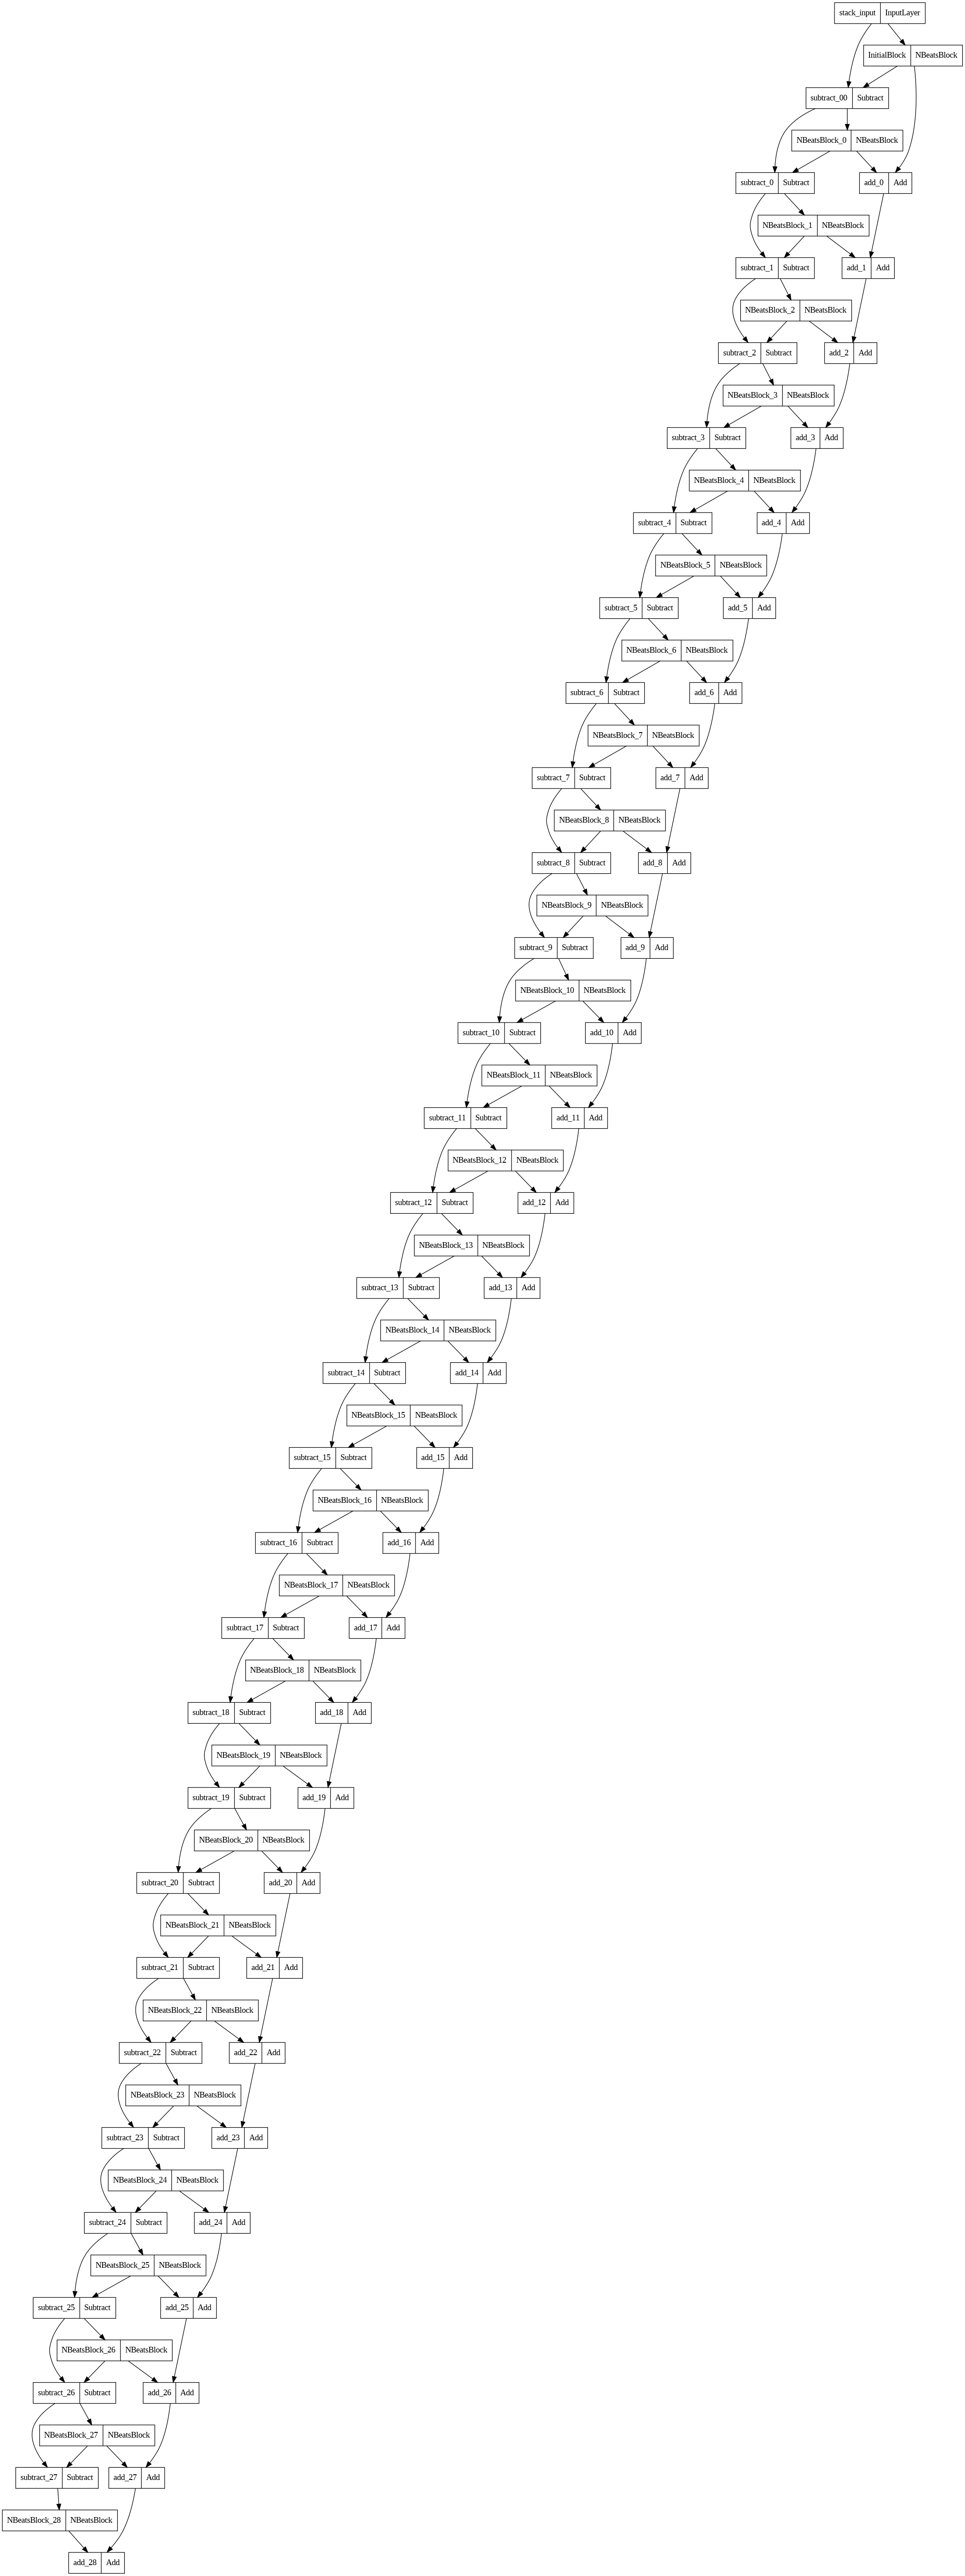

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

> Ensemble Model

- Combining several Dense models with different loss functions.

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  ensemble_models = []

  for i in range(num_iter):
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      model = tf.keras.Sequential([
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)
      ])

      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])

      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])

      ensemble_models.append(model)

  return ensemble_models

In [ ]:
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 874: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 999: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 807: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 907: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 318: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 111: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 790: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 890: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by redu

In [ ]:
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 49ms/step


<tf.Tensor: shape=(15, 501), dtype=float32, numpy=
array([[148.55025, 150.72485, 151.34499, ..., 176.90547, 179.29723,
        178.80748],
       [147.00983, 151.95906, 153.05666, ..., 176.80714, 180.03554,
        178.21898],
       [148.26347, 149.31636, 151.03293, ..., 177.01717, 179.54774,
        179.67238],
       ...,
       [148.74197, 150.20557, 151.11095, ..., 178.38158, 180.41486,
        180.36015],
       [148.30719, 149.71652, 152.74387, ..., 176.89447, 179.86307,
        180.63763],
       [147.66376, 152.71327, 152.81357, ..., 177.3948 , 180.17749,
        178.0357 ]], dtype=float32)>

In [ ]:
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 2.0436995,
 'mse': 6.934129,
 'rmse': 2.6332736,
 'mape': 1.3096764,
 'mase': 1.0937797}

> Comparing Results

In [ ]:
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_dense_w14_h1": model_4_results,
                              "model_5_CONV1D": model_5_results,
                              "model_6_LSTM": model_6_results,
                              "model_7_NBEATs": model_7_results,
                              "model_8_ensemble": ensemble_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,1.866336,5.700585,2.387590,1.195494,0.998805
model_1_dense_w7_h1,2.284844,8.429027,2.903279,1.462202,1.221024
model_2_dense_w30_h1,2.392829,9.558344,3.091657,1.527333,1.276652
model_3_dense_w30_h7,4.692078,36.259491,5.334900,2.997744,2.505793
model_4_dense_w14_h1,2.235896,8.229485,2.868708,1.432765,1.196642
model_5_CONV1D,2.544268,10.901638,3.301763,1.630556,1.361682
model_6_LSTM,2.171828,8.081162,2.842739,1.393582,1.162353
model_7_NBEATs,1.911571,6.184323,2.486830,1.223891,1.023065
model_8_ensemble,2.043700,6.934129,2.633274,1.309676,1.093780


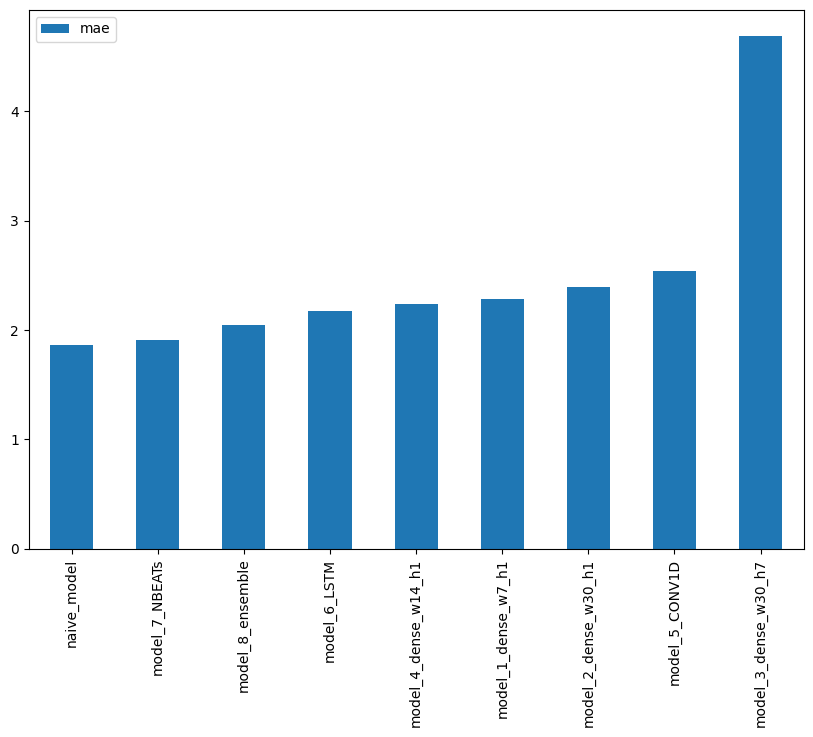

In [ ]:
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

> Conclusion

- The N-BEATS model outperforms all other prediction models, but performs slightly less well than the baseline model.
